In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [2]:
def plot_data(data, x, y, outdir, tag, title, timing=None, smooth=1):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[y])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[y] = smoothed_x
            
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
        if timing:
            data = data[data.timing == timing].drop('timing', axis=1)

    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.set(style="whitegrid", font_scale=1.5)
    sns.set_palette('Set2') # or husl
    if 'timing' in data.columns:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag, style='timing')
    else:
        sns.lineplot(x=x, y=y, ax=ax, data=data, hue=tag)
    ax.grid(True, alpha=0.8, linestyle=':')
    ax.legend(loc='best').set_draggable(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if timing:
        title = f'{title}-{timing}'
    outpath = f'{outdir}/{title}.png'
    ax.set_title(title)
    fig.savefig(outpath)
    fig.show()
    print(f'Plot Path: {outpath}')

def get_datasets(files, tag, condition=None):
    unit = 0
    datasets = []
    for f in files:
        assert f.endswith('log.txt')
        data = pd.read_csv(f, sep='\t')

        data.insert(len(data.columns), tag, condition)

        datasets.append(data)
        unit +=1

    return datasets

In [23]:
def setup(obj):
    def _getattr(self, name):
        if name.startswith('_'):
            raise AttributeError("attempted to get missing private attribute '{}'".format(name))
        return getattr(self.d, name)
    obj.d = dict()
    for a in dir(obj.d):
        if not a.startswith('_'):
            setattr(obj, a, getattr(obj.d, a))
#     setattr(obj, '__getattribute__', obj.d.__getattribute__)

    
class A:
    def __init__(self):
        self.d = []


a = A()
setup(a)
a.items()

dict_items([])

In [28]:
import functools
def f(a, b, c, d):
    print(a, b, c, d)

g = functools.partial(f, 1, 2)
g(3, 4, a=10)

TypeError: f() got multiple values for argument 'a'

In [80]:
import tensorflow as tf
def static_scan(fn, start, inputs, reverse=False):
    """ Sequentially apply fn to inputs, with starting state start.
    inputs are expected to be time-major, and the outputs of fn are expected
    to have the same structure as start. 
    This function is equivalent to 
    tf.scan(
        fn=fn
        elems=inputs, 
        initializer=start,
        parallel_iterations=1,
        reverse=reverse
    )
    In practice, we find it's faster than tf.scan
    """
    last = start
    outputs = [[] for _ in tf.nest.flatten(start)]
    indices = range(len(tf.nest.flatten(inputs)[0]))
    if reverse:
        indices = reversed(indices)
    for index in indices:
        # extract inputs at step index
        inp = tf.nest.map_structure(lambda x: x[index], inputs)
        last = fn(last, inp)
        # distribute outputs
        [o.append(l) for o, l in zip(outputs, tf.nest.flatten(last))]
    if reverse:
        outputs = [list(reversed(x)) for x in outputs]
    outputs = [tf.stack(x) for x in outputs]
    # reconstruct outputs to have the same structure as start
    return tf.nest.pack_sequence_as(start, outputs)

def v_trace(reward, value, next_value, pi, mu, discount, lambda_=1, 
        c_clip=1, rho_clip=1, rho_clip_pg=1, axis=0):
    """
    Params:
        discount = gamma * (1-done). 
        axis specifies the time dimension
    """
#     assert_rank_and_shape_compatibility(
#         [reward, value, next_value, pi, mu, discount])
    
    ratio = pi / mu
    
    # swap 'axis' with the 0-th dimension
    dims = list(range(reward.shape.ndims))
    dims = [axis] + dims[1:axis] + [0] + dims[axis + 1:]
    if axis != 0:
        reward = tf.transpose(reward, dims)
        value = tf.transpose(value, dims)
        next_value = tf.transpose(next_value, dims)
        ratio = tf.transpose(ratio, dims)
        discount = tf.transpose(discount, dims)
    
    clipped_c = ratio if c_clip is None else tf.minimum(ratio, c_clip)
    clipped_rho = ratio if rho_clip is None else tf.minimum(ratio, rho_clip)
    if lambda_ is not None and lambda_ != 1:
        clipped_rho = lambda_ * clipped_rho

    delta = clipped_rho * (reward + discount * next_value - value)
    
    initial_value = tf.zeros_like(delta[-1])

    v_minus_V = static_scan(
        lambda acc, x: x[0] + x[1] * x[2] * acc,
        initial_value, (delta, discount, clipped_c),
        reverse=True)
    
    vs = v_minus_V + value

    next_vs = tf.concat([vs[1:], next_value[-1:]], axis=0)
    clipped_rho_pg = ratio if rho_clip_pg is None else tf.minimum(ratio, rho_clip_pg)
    adv = clipped_rho_pg * (reward + discount * next_vs - value)

    if axis != 0:
        vs = tf.transpose(vs, dims)
        adv = tf.transpose(adv, dims)
    
    return vs, adv

tf.nest.map_structure(lambda x: x.numpy(), v_trace(**tf.nest.map_structure(
    lambda x: tf.convert_to_tensor(x, tf.float32), values)))

(array([[ 9.209749 ,  8.690623 ,  5.6069465],
        [ 9.360001 ,  5.378809 , 10.760001 ]], dtype=float32),
 array([[ 9.209749 ,  9.446628 ,  4.9402804],
        [15.580001 ,  4.0454755, 16.946669 ]], dtype=float32))

In [77]:
def vtrace_from_importance_weights(reward, value, next_value, pi, mu, discount, lambda_=1,
    c_clip=1, rho_clip=1.0, rho_clip_pg=1.0,
    name='vtrace_from_importance_weights'):

    log_rhos = tf.convert_to_tensor(tf.math.log(pi/mu), dtype=tf.float32)
    discounts = tf.convert_to_tensor(discount, dtype=tf.float32)
    rewards = tf.convert_to_tensor(reward, dtype=tf.float32)
    values = tf.convert_to_tensor(value, dtype=tf.float32)
    bootstrap_value = tf.convert_to_tensor(next_value[-1], dtype=tf.float32)
    if rho_clip is not None:
        clip_rho_threshold = tf.convert_to_tensor(rho_clip, dtype=tf.float32)
    if rho_clip_pg is not None:
        clip_pg_rho_threshold = tf.convert_to_tensor(rho_clip_pg, dtype=tf.float32)

    # Make sure tensor ranks are consistent.
    rho_rank = log_rhos.shape.ndims  # Usually 2.
    values.shape.assert_has_rank(rho_rank)
    bootstrap_value.shape.assert_has_rank(rho_rank - 1)
    discounts.shape.assert_has_rank(rho_rank)
    rewards.shape.assert_has_rank(rho_rank)
    if clip_rho_threshold is not None:
        clip_rho_threshold.shape.assert_has_rank(0)
    if clip_pg_rho_threshold is not None:
        clip_pg_rho_threshold.shape.assert_has_rank(0)

    rhos = tf.exp(log_rhos)
    if clip_rho_threshold is not None:
        clipped_rhos = tf.minimum(clip_rho_threshold, rhos, name='clipped_rhos')
    else:
        clipped_rhos = rhos

    cs = tf.minimum(c_clip, rhos, name='cs')
    # Append bootstrapped value to get [v1, ..., v_t+1]
    values_t_plus_1 = tf.concat(
        [values[1:], tf.expand_dims(bootstrap_value, 0)], axis=0)
    deltas = clipped_rhos * (rewards + discounts * values_t_plus_1 - values)

    # Note that all sequences are reversed, computation starts from the back.
    sequences = (
        tf.reverse(discounts, axis=[0]),
        tf.reverse(cs, axis=[0]),
        tf.reverse(deltas, axis=[0]),
    )
    # V-trace vs are calculated through a scan from the back to the beginning
    # of the given trajectory.
    def scanfunc(acc, sequence_item):
        discount_t, c_t, delta_t = sequence_item
        return delta_t + discount_t * c_t * acc

    initial_values = tf.zeros_like(bootstrap_value)
    vs_minus_v_xs = tf.scan(
        fn=scanfunc,
        elems=sequences,
        initializer=initial_values,
        parallel_iterations=1,
        back_prop=False,
        name='scan')
    # Reverse the results back to original order.
    vs_minus_v_xs = tf.reverse(vs_minus_v_xs, [0], name='vs_minus_v_xs')

    # Add V(x_s) to get v_s.
    vs = tf.add(vs_minus_v_xs, values, name='vs')

    # Advantage for policy gradient.
    vs_t_plus_1 = tf.concat([
        vs[1:], tf.expand_dims(bootstrap_value, 0)], axis=0)
    if clip_pg_rho_threshold is not None:
        clipped_pg_rhos = tf.minimum(clip_pg_rho_threshold, rhos,
                                   name='clipped_pg_rhos')
    else:
        clipped_pg_rhos = rhos
    pg_advantages = (
        clipped_pg_rhos * (rewards + discounts * vs_t_plus_1 - values))

    # Make sure no gradients backpropagated through the returned values.
    return tf.stop_gradient(vs), tf.stop_gradient(pg_advantages)

tf.nest.map_structure(lambda x: x.numpy(), vtrace_from_importance_weights(**tf.nest.map_structure(
    lambda x: tf.convert_to_tensor(x, tf.float32), values)))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.scan(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.scan(fn, elems))


(array([[ 9.209749 ,  8.690623 ,  5.6069465],
        [ 9.360001 ,  5.378809 , 10.760001 ]], dtype=float32),
 array([[ 9.209749 ,  9.446628 ,  4.9402804],
        [15.580001 ,  4.0454755, 16.946669 ]], dtype=float32))

In [14]:
A = np.array([[3, 0], [5, 1]])
x = np.array([.5, .5])
y = np.array([.75, .25])
i = 0
x * ((A @ y) - x @ A @ y)

array([-0.4375,  0.4375])

In [13]:
B = np.array([[3, 5], [0, 1]])
x = np.array([.5, .5])
y = np.array([.75, .25])
i = 1
y * ((x @ B) - x @ B @ y)

array([-0.28125,  0.28125])

In [20]:
%%timeit
np.swapaxes(x, 0, 1)

10.7 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
y = np.array(x)
np.swapaxes(y, 0, 1)

10 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
np.array(x).ndim

3

In [22]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class QMixer(nn.Module):
    def __init__(self, args):
        super(QMixer, self).__init__()

        self.args = args
        self.n_agents = args.n_agents
        self.state_dim = int(np.prod(args.state_shape))

        self.embed_dim = args.mixing_embed_dim

        if getattr(args, "hypernet_layers", 1) == 1:
            self.hyper_w_1 = nn.Linear(self.state_dim, self.embed_dim * self.n_agents)
            self.hyper_w_final = nn.Linear(self.state_dim, self.embed_dim)
        elif getattr(args, "hypernet_layers", 1) == 2:
            hypernet_embed = self.args.hypernet_embed
            self.hyper_w_1 = nn.Sequential(nn.Linear(self.state_dim, hypernet_embed),
                                           nn.ReLU(),
                                           nn.Linear(hypernet_embed, self.embed_dim * self.n_agents))
            self.hyper_w_final = nn.Sequential(nn.Linear(self.state_dim, hypernet_embed),
                                           nn.ReLU(),
                                           nn.Linear(hypernet_embed, self.embed_dim))
        elif getattr(args, "hypernet_layers", 1) > 2:
            raise Exception("Sorry >2 hypernet layers is not implemented!")
        else:
            raise Exception("Error setting number of hypernet layers.")

        # State dependent bias for hidden layer
        self.hyper_b_1 = nn.Linear(self.state_dim, self.embed_dim)

        # V(s) instead of a bias for the last layerst
        self.V = nn.Sequential(nn.Linear(self.state_dim, self.embed_dim),
                               nn.ReLU(),
                               nn.Linear(self.embed_dim, 1))

    def forward(self, agent_qs, states):
        bs = agent_qs.size(0)
        states = states.reshape(-1, self.state_dim)
        agent_qs = agent_qs.view(-1, 1, self.n_agents)
        # First layer
        w1 = th.abs(self.hyper_w_1(states))
        b1 = self.hyper_b_1(states)
        w1 = w1.view(-1, self.n_agents, self.embed_dim)
        b1 = b1.view(-1, 1, self.embed_dim)
        hidden = F.elu(th.bmm(agent_qs, w1) + b1)
        # Second layer
        w_final = th.abs(self.hyper_w_final(states))
        w_final = w_final.view(-1, self.embed_dim, 1)
        # State-dependent bias
        v = self.V(states).view(-1, 1, 1)
        # Compute final output
        y = th.bmm(hidden, w_final) + v
        # Reshape and return
        q_tot = y.view(bs, -1, 1)
        return q_tot


In [25]:
class Args:
    def __init__(self):
        self.state_shape = (3, 4)
        self.n_agents = 3
        self.mixing_embed_dim = 9
args = Args()
qmix = QMixer(args)

In [136]:
B = 3
A = 2
H = 4
x = tf.random.normal((B, A))
y = tf.random.normal((B, A, H))
tf.einsum('ba,bah->bh', x, y)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 1.5370384 , -0.09481981, -1.6808445 ,  1.0012864 ],
       [ 2.5243452 , -1.909442  ,  0.69922054, -1.9831874 ],
       [ 1.7966232 ,  1.1815207 , -2.9724448 , -2.1147866 ]],
      dtype=float32)>

In [139]:
xe = tf.expand_dims(x, 1)
np.squeeze(tf.matmul(xe, y), axis=1)

array([[ 1.5370384 , -0.09481981, -1.6808445 ,  1.0012864 ],
       [ 2.5243452 , -1.909442  ,  0.69922054, -1.9831874 ],
       [ 1.7966232 ,  1.1815207 , -2.9724448 , -2.1147866 ]],
      dtype=float32)

In [70]:
np.shape(10)

IndexError: tuple index out of range

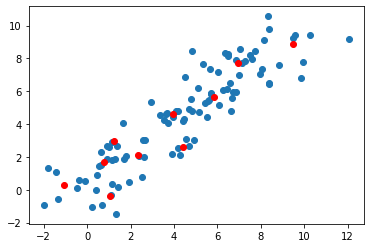

In [206]:
def nearest_cluster_idx(centroids, feat):
    return np.argmin(np.mean((centroids - feat[None])**2, -1))

def kmean(data, k, n):
    max_feat = np.max(data, 0)
    min_feat = np.min(data, 0)
    step = data.shape[0] // k
    centroids = data[:k]
    
    for _ in range(n):
        feats = [[] for _ in range(k)]
        for feat in data:
            i = nearest_cluster_idx(centroids, feat)
            feats[i].append(feat)
        centroids = np.array([np.mean(fs, axis=0) for fs in feats])
    return centroids

data = np.concatenate([np.random.normal(i, 1, (10, 2)) for i in range(10)], 0)
np.random.shuffle(data)
centroids = kmean(data, 10, 100)
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r')
plt.show()

In [181]:
b_e = tf.expand_dims(b, 1)
a_t = tf.transpose(a, [0, 2, 1])
x = tf.squeeze(tf.matmul(b_e, a_t))
tf.where(x == 0, -1e10, x)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-1.0000000e+10, -4.3082278e-02,  7.8758178e-03, -1.0000000e+10,
        -5.6906357e-02],
       [ 1.9747494e-03, -1.0000000e+10, -1.0000000e+10, -1.0000000e+10,
        -1.0000000e+10]], dtype=float32)>

In [219]:
import psutil
process = pszutil.Process()
process.memory_info().rss

156672000

In [284]:
d = {'a': 10, 'b': 20}
set(d.keys())

{'a', 'b'}

In [276]:
x = tf.zeros((2, 2, 2, 4))
pool = tf.ones((2, 2, 1, 4))
n = x.shape[-1]
feat = tf.reshape(tf.range(n, dtype=tf.int32), (1, 1, 1, -1))
x = tf.where(feat < tf.cast(n * .25, tf.int32), pool, x)
x

<tf.Tensor: shape=(2, 2, 2, 4), dtype=float32, numpy=
array([[[[1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.]]],


       [[[1., 0., 0., 0.],
         [1., 0., 0., 0.]],

        [[1., 0., 0., 0.],
         [1., 0., 0., 0.]]]], dtype=float32)>